In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
data = pd.read_csv('data\survey_data.csv',low_memory=False)

In [3]:
#split out demographic data
demo_columns = ['age','age_category','gender','education','employment_status','household_income','subjective_income',
                'geography','region','country','country_code','country_income','national_weight','population_weight',
                'Q1','Q2','Q3','Q4','Q5A','Q5B','Q5C','Q6','Q7','Q27','Q28','D1','Q29','Q30','ViewOfScience','Q6','Q7']

In [4]:
#add demographic data to dictionaries mapped from id
for i in demo_columns:
    globals()[i] = dict(zip(data['id'],data[i]))

In [5]:
#split out data to go into k-means model
df = data[['id','Q8', 'Q9', 'Q10A', 'Q10B', 'Q11A', 'Q11B',
       'Q11C', 'Q11D', 'Q11E', 'Q11F', 'Q11G', 'Q12', 'Q13', 'Q14A', 'Q14B',
       'Q15A', 'Q15B', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22',
       'Q24', 'Q25', 'Q26']].copy()

In [6]:
#Q20 is a discrete choice which doesn't scale as an intuititive magnitude
#so data can be revised to answer question: do you trust doctor/nurse MOST to give you medical or health advice? Yes=1, different most trusted answer given = 0
def convAuthority(x):
    if x == 'doctor/nurse':
        return 1.0
    elif x == '!' or x == '?' or str(x) == 'nan':
        return None
    else:
        return 0

df['Q20'] = df['Q20'].apply(lambda x:convAuthority(x))

In [7]:
#standardise and remove rows with null fields and rows with questions unanswered
def nullResults(df):
    def nanNoAnswer(x):
        if x == '!' or x == '?' or str(x) == 'nan':
            return None
        else:
            return x
    
    for i in df.columns:
        df[i] = df[i].apply(lambda x:nanNoAnswer(x))
    
    df = df.dropna().reset_index()
    del df['index']
    
    return df

df = nullResults(df)

#all columns as float datatype
for i in df.columns[1:]:
    df[i] =  df[i].astype(float)

In [8]:
#pull features to be used for k-means into np.array

features = df.columns[1:]
X = df[features].values

In [9]:
#run kmeans for clsuter size = 1,2...10 and append to list

models = []
for n in tqdm(range(1,11)):
    kmeans = KMeans(n_clusters=n)
    models.append(kmeans.fit(X))
#print("model\n", model)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.58s/it]


In [10]:
def parallelPlot(df):
    '''plot feature centroids for each cluster'''
    colors = ['b', 'r', 'g', 'y', 'k', 'm','c','0.6','orange','tomato']
    x = df.columns
    
    plt.figure(figsize=(16,4))
    for i in range(n):
        plt.plot(x,df.loc[i], c=colors[i], marker='o', label='cluster_'+str(i))
    plt.margins(x=0.01, y=0.03, tight=True)
    plt.gca().set_ylim([-0.05,1.05])
    plt.grid()
    plt.legend(loc=4)

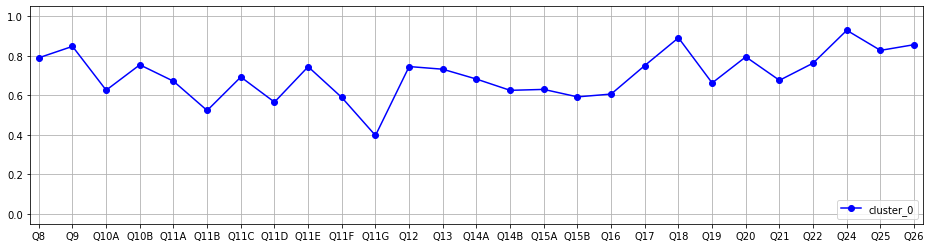

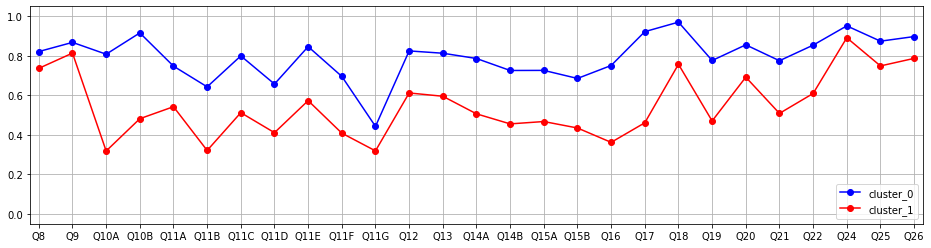

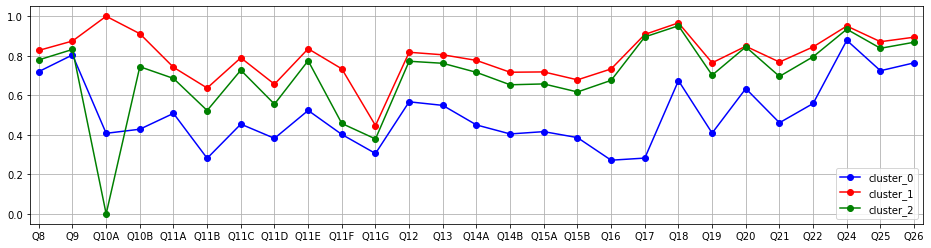

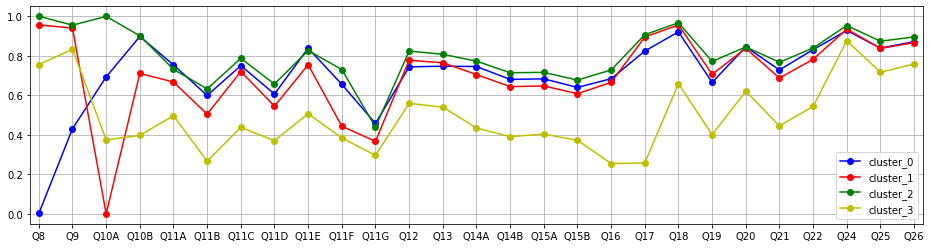

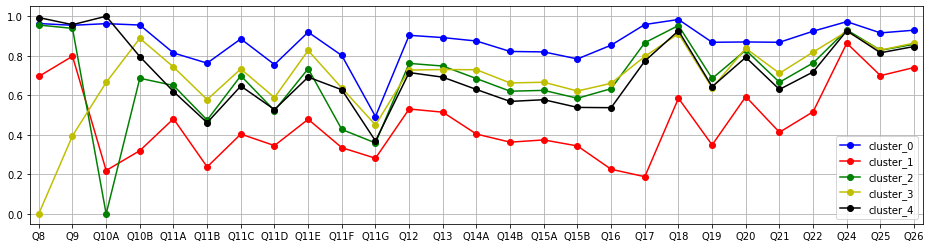

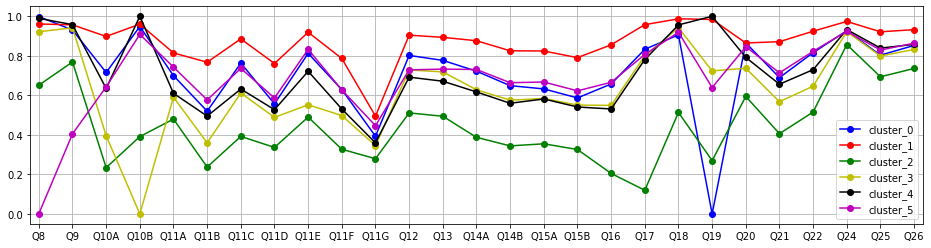

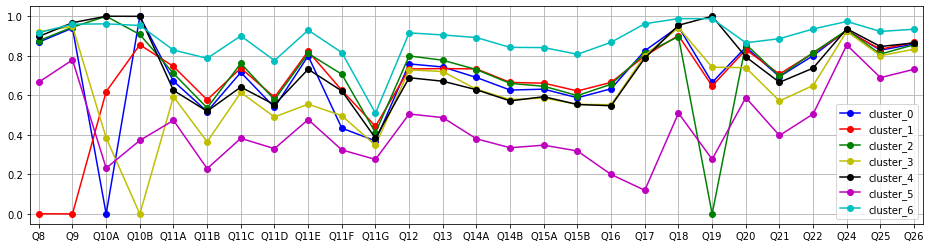

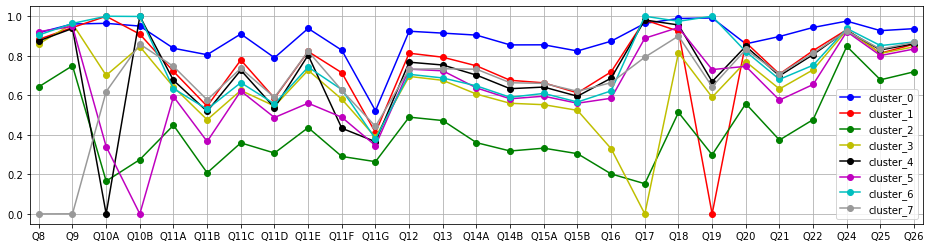

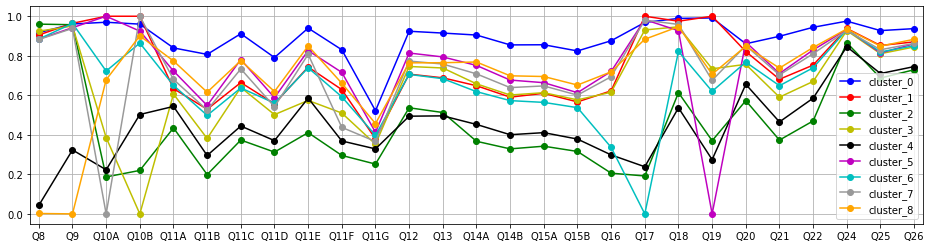

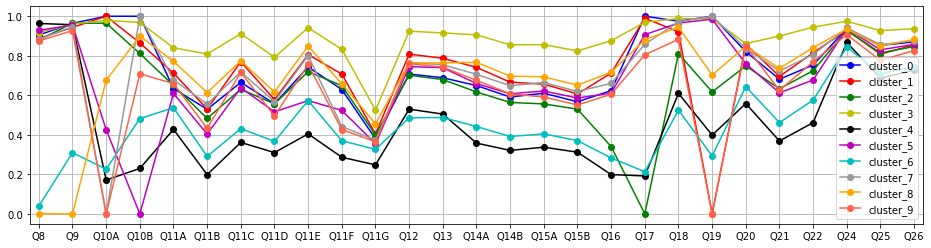

In [11]:
#plot kmeans model as parallel plot, with centroid value for each question
n = 1
for model in models:
    centers = model.cluster_centers_
    
    P = pd.DataFrame(centers,columns=features)
    
    parallelPlot(P)
    n+=1

In [12]:
#mean total = models[0], one cluster
centers = models[0].cluster_centers_
range_df = pd.DataFrame(centers,columns=features)

#add cluster centroids from kmeans = 10, cluster_5 and cluster_8
centers = models[9].cluster_centers_
df2 = pd.DataFrame(centers,columns=features)
range_df = range_df.append(df2.loc[3])
range_df = range_df.append(df2.loc[4]).reset_index().drop(columns='index')

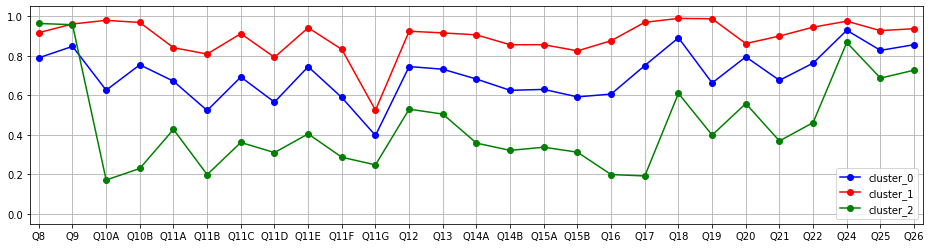

In [13]:
n = 3
parallelPlot(range_df)

In [14]:
#add cluster_n column from model_9 (K=10)
ids = df.pop('id')
df['cluster_n'] = KMeans.fit_predict(models[9], df, y=None, sample_weight=None)
df.insert (0, 'id', ids)

#add demographic info to sample rows
for i in demo_columns:
    df[i] = df['id'].apply(lambda x:globals()[i].get(x))

In [15]:
#rename cluster labels with some description of cluster
#nb* cluster_index will vary per kmeans run

cluster_dict = {
    0:'averagely high trust',
    1:'v high belief science/tech will reduce local jobs in next 5 years',
    2:'no belief that scientists work to benefit people like you in country',
    3:'highest trust',
    4:'lowest trust/high desire to know more about science, medicine/disease/health',
    5:'no confidence in hospitals and clinics',
    6:'low trust/no desire to know more about science, medicine/disease/health',
    7:'no confidence in NGOs',
    8:'high trust/no desire to know more about science, medicine/disease/health',
    9:'no trust in NGOs/non-profit/high desire to know more about science, medicine/disease/health'
    }
    
    
#'no trust in NGOs/non-profit',
#'no confidence in NGOs/hospitals and clinics',
#'v high belief science/tech will reduce local jobs in next 5 years',
#'no desire to know more about science, medicine/disease/health',
#'no belief that scientists work to benefit people like you in country',
#'low trust/no desire to know more about science, medicine/disease/health',
#'lowest trust/high desire to know more about science, medicine/disease/health',
#'highest trust',
#'no trust in doctor/nurse to give advice',
#'high trust, v high for health pros'
#'no desire to know more about science, medicine/disease/health',
#'no trust in NGOs/non-profit',
#'high trust, v high for health pros',
#'no trust in scientists',
#'lowest trust/high desire to know more about science, medicine/disease/health',
#'no trust in doctors/nurses',
#'no confidence in NGOs/hospitals and clinics',
#'no confidence in NGOs',
#'low trust/no desire to know more about science, medicine/disease/health',
#'highest trust'
    
df['cluster_description'] = df['cluster_n'].apply(lambda x:cluster_dict.get(x))

#now have all samples with cluster label, cluster description and demographic data, so we can look at distribution of clsuters across demographic factors